In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [19]:
DATA_PATH = '/content/drive/MyDrive/dataset_real.json'

In [20]:
def load_data(data_path):
    '''Load training data from json file
    
    -Parameters
    '''
    
    with open(data_path, 'r') as fp:
        data = json.load(fp)

    X = np.array(data['mfcc'], dtype=object)
    y = np.array(data['labels'])
    
    return X,y


In [21]:
X, y = load_data(DATA_PATH)
y.shape

(1240,)

In [22]:
def prepare_datasets(data_path, test_size, validation_size):
    
    X, y = load_data(data_path)

    X = X.astype('float32')
    y = y.astype('int64')

    for i in range(len(y)):
      if y[i] in [3, 4, 5]:
        y[i] -= 1
      
    y = y-1
    X_shuffle, y_shuffle = shuffle(X, y)


    X_train, X_test, y_train, y_test = train_test_split(X_shuffle, y_shuffle, test_size=0.25)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)


    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [23]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(DATA_PATH, 0.25, 0.2)

In [24]:
y_train.shape

(744,)

In [25]:
# Build model
def build_model(input_shape):
    
    model = keras.Sequential()
    
    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))
    
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    
    return model

In [26]:
X_train.shape

(744, 44, 20)

In [30]:
# Create network
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

# Compile model
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss=keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.summary()

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),batch_size=32, epochs=30)
print(X_train.shape)

#Evaluate the LSTM test set
print('Evaluate the LSTM on test set')
test_error, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: {}'.format(test_accuracy))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 44, 64)            21760     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 59,594
Trainable params: 59,594
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
24/24 [==============================] - 5s 89ms/step - loss: 2.3046 - accuracy: 0.0766 - val_loss: 2.166

In [28]:
def plot_history(history):

  fig, axs = plt.subplots(2)

  # create accuracy subplot
  axs[0].plot(history.history['accuracy'], label='train accuracy')
  axs[0].plot(history.history['val_accuracy'], label='test accuracy')
  axs[0].set_ylabel('Accuracy')
  axs[0].legend()
  axs[0].set_title('accuracy eval')

  # create error subplot
  axs[1].plot(history.history['loss'], label='train error')
  axs[1].plot(history.history['val_loss'], label='test error')
  axs[1].set_ylabel('loss')
  axs[1].legend()
  axs[1].set_title('loss eval')

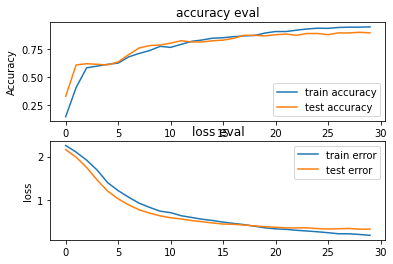

In [29]:
plot_history(history)

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_prediction)

figure, ax = plt.subplots(figsize = (6,6))
sns.set(font_scale = 1.6)
sns.heatmap(cm, annot = True, linewidths=.5, ax=ax)